<a href="https://colab.research.google.com/github/semi0612/cat_and_dog_vgg/blob/master/cat_dog_2000_load.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

개고양이 이미지를 분류하는 코드

2000장의 train_data, 500장의 valid_data

훈련은 VGG16 모델을 불러와 사용

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install -q tf-nightly-2.0-preview
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, shutil
import cv2
import matplotlib.pyplot as plt
import copy
import tqdm
from PIL import Image
import glob

%matplotlib inline

     |████████████████████████████████| 95.2MB 84kB/s 
     |████████████████████████████████| 3.8MB 29.0MB/s 
     |████████████████████████████████| 450kB 47.8MB/s 
     |████████████████████████████████| 81kB 10.7MB/s 
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.11.0 which is incompatible.
ERROR: tb-nightly 2.1.0a20191206 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.


In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


2500개의 데이터 로드

로드한 데이터 처리하기

In [0]:
label=[]    #공간 확보
data=[]     #공간 확보
counter=0

IMAGE_SIZE = 80

path = '/content/gdrive/My Drive/cat_and_dog/train_2500'  #path = '/링크'

#try : 데이터 전처리하기, 0~1 사이로 만들기
#train_2500 폴더 안에 랜덤으로 들어가 있는 2500개의 이미지를
#앞글자가 cat인 경우 0, 앞글자가 dog일 경우 1 => 정답레이블 만들기

for file in os.listdir(path):
    image_data=cv2.imread(os.path.join(path,file), cv2.IMREAD_COLOR)
    image_data=cv2.resize(image_data,(IMAGE_SIZE,IMAGE_SIZE))
    try:
        data.append(image_data/255.0)
    except:
        label=label[:len(label)-1]
    if file.startswith("cat"):
        label.append(0)
    elif file.startswith("dog"):
        label.append(1)
    counter+=1
    if counter%100==0:
        print (counter," image data retreived") #100개 완료되었을때마다 출력해주ㅓ라

data=np.array(data)
data=data.reshape((data.shape)[0],(data.shape)[1],(data.shape)[2],3)
label=np.array(label)

print (data.shape)
print (label.shape)

100  image data retreived
200  image data retreived
300  image data retreived
400  image data retreived
500  image data retreived
600  image data retreived
700  image data retreived
800  image data retreived
900  image data retreived
1000  image data retreived
1100  image data retreived
1200  image data retreived
1300  image data retreived
1400  image data retreived
1500  image data retreived
1600  image data retreived
1700  image data retreived
1800  image data retreived
1900  image data retreived
2000  image data retreived
2100  image data retreived
2200  image data retreived
2300  image data retreived
2400  image data retreived
2500  image data retreived
(2500, 80, 80, 3)
(2500,)


In [0]:
#파일 나누기
#불러온 파일을 train 0.8 / test0.2 비율로 나누기
#random_state = 값 지정시 반복 연산 시에 동일한 결과를 얻을 수 있게 한다.

from sklearn.model_selection import train_test_split

train_data, valid_data, train_label, valid_label = train_test_split(data, label, test_size=0.2, random_state=42)

print(train_data.shape)
print(train_label.shape)
print(valid_data.shape)
print(valid_label.shape)


(2000, 80, 80, 3)
(2000,)
(500, 80, 80, 3)
(500,)


In [0]:
#이미 훈련된 VGG16 끌어오기 
from keras.applications.vgg16 import VGG16

#weights='imagenet'으로 값을 주면 이미지넷으로 트레이닝 된 모델을 불러올 수 있다
#하지만 여기서는 값을 주었을때 loss값과 acc값이 제대로 나오지 않아 None으로 설정.
#include_top= 상단의 F.C 레이어를 포함할 것인이 아닌지 결정하는 파라미터
model_vgg = tf.keras.applications.VGG16(weights     = None,
                                        include_top = False,
                                        input_shape=(80, 80, 3))

model_vgg.summary()

Using TensorFlow backend.


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 80, 80, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 80, 80, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 40, 40, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 40, 40, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 40, 40, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 20, 20, 128)       0     

In [0]:
#불러오면서 날린 Dence layer를 만들어 뒤에 연결해주기

from tensorflow.keras import layers

model = tf.keras.Sequential()
model.add(model_vgg)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation  = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 15,239,489
Trainable params: 15,239,489
Non-trainable params: 0
_________________________________________________________________


In [0]:
#모델 학습과정 설정하기
#개 vs 고양이의 이진분류 => binary_crossentropy
#metrics=모델이 컴파일될 때 모델 수행 결과를 나타내게끔 설정하는 부분
#정확돌르 측정하기 위해 사용되는 test 샘플을 학습 과정에서 제외시킴으로 오버피팅을 방지
from keras import optimizers

RMSprop = tf.optimizers.RMSprop(lr=1e-4)

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop,
              metrics=['acc'])


In [0]:
#모델로 학습시키기
BATCH_SIZE=20

train_history = model.fit(train_data,train_label,validation_data=(valid_data,valid_label),
                          epochs=15,
                          batch_size=BATCH_SIZE)

Train on 2000 samples, validate on 500 samples
Epoch 1/15
2000/2000 [==============================] - 636s 318ms/sample - loss: 0.6935 - acc: 0.4765 - val_loss: 0.6931 - val_acc: 0.4980
Epoch 2/15
2000/2000 [==============================] - 612s 306ms/sample - loss: 0.6938 - acc: 0.5020 - val_loss: 0.6900 - val_acc: 0.6040
Epoch 3/15
2000/2000 [==============================] - 595s 298ms/sample - loss: 0.6949 - acc: 0.5665 - val_loss: 0.6735 - val_acc: 0.6020
Epoch 4/15
2000/2000 [==============================] - 596s 298ms/sample - loss: 0.6806 - acc: 0.5825 - val_loss: 0.6441 - val_acc: 0.6340
Epoch 5/15
2000/2000 [==============================] - 593s 297ms/sample - loss: 0.6686 - acc: 0.5935 - val_loss: 0.6605 - val_acc: 0.5820
Epoch 6/15
2000/2000 [==============================] - 584s 292ms/sample - loss: 0.6570 - acc: 0.6160 - val_loss: 0.6298 - val_acc: 0.6120
Epoch 7/15
2000/2000 [==============================] - 586s 293ms/sample - loss: 0.6477 - acc: 0.6045 - val_loss

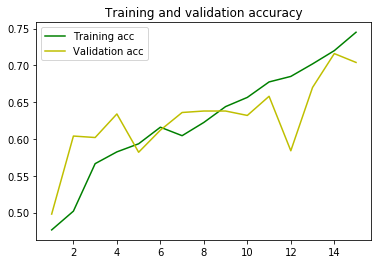

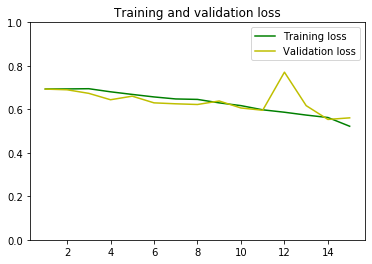

In [0]:
acc = train_history.history['acc']
val_acc = train_history.history['val_acc']
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'y', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.ylim(0.0, 1.0)

plt.show()